In [187]:
import pandas as pd, numpy as np
from timeit import default_timer as timer
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, BatchNormalization,Normalization
from tensorflow.python.keras.layers.recurrent import LSTM
from keras.optimizers import SGD
from keras.metrics import binary_accuracy
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Model
# from keras.utils.vis_utils import plot_model
import tensorflow as tf
from keras import metrics
import pickle as pkl
import tensorflow.keras.backend as K
import zipcodes
from operator import itemgetter
from tensorflow_addons.metrics import F1Score
from itertools import chain
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
pd.set_option('display.max_rows', None)
import seaborn as sns

In [118]:
ecom_df = pd.read_csv('sample_data.csv')
ecom_df=ecom_df.drop('Unnamed: 0',axis=1)
ecom_df.head(3)

,AMPERITY_ID,TOTAL_ORDERS,ECOM_TOTAL_ORDERS,STORE_TOTAL_ORDERS,CANCELLED_ORDERS,RETURNED_ORDERS,ECOM_RETURNED_ORDERS,STORE_RETURNED_ORDERS,GROSS_ORDERED_QUANTITY,ECOM_GROSS_ORDERED_QUANTITY,...,SEC_SPEND_MEN,SEC_SPEND_SUNGLASSES,SEC_SPEND_WOMEN,TOT_SEC_SPENT_R,NO_OF_SESSIONUUIDS_R,POSTAL,DISTANCE_TO_CLOSEST_STORE,PREFERRED_STORE_ID,IS_LOYAL_CUSTOMER,LOYALTY_FIRST_DATE
0,581835f0-c5fc-372c-aa41-b2c63a6ddc9f,2,2,0,0,1,1,0,3,3,...,NaN,NaN,NaN,NaN,NaN,34982-7112,NaN,789,0,NaN
1,5966b4db-0952-3ace-94aa-76c60894d6dc,1,1,0,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,85743,6.383023,789,0,NaN
2,b9f602ca-9662-3e1d-8cfd-ef2b1293c582,1,1,0,0,0,0,0,2,2,...,NaN,NaN,NaN,NaN,NaN,7936,0.803065,789,0,NaN


In [119]:
print("Shape of the dataset:",ecom_df.shape)
ecom_df = ecom_df[~ecom_df['CHURNED'].isnull()]
print("Null values in target variable:",ecom_df['CHURNED'].isnull().sum())

Shape of the dataset: (500000, 117)
Null values in target variable: 0


In [120]:
ex_col = ['AMPERITY_ID','FIRST_ORDERED_DATE','LAST_ORDERED_DATE','ECOM_FIRST_ORDERED_DATE',
          'ECOM_LAST_ORDERED_DATE','STORE_FIRST_ORDERED_DATE','STORE_LAST_ORDERED_DATE','CUST_TYPE',
          'CHURNED','CUST_SEG','SS_EMAIL','POSTAL','LOYALTY_FIRST_DATE'
         ]
in_col = list(filter(lambda x: x not in ex_col, ecom_df.columns))

cols_to_convert = ecom_df[in_col].select_dtypes(include='object').columns
ecom_df[cols_to_convert] = ecom_df[cols_to_convert].apply(pd.to_numeric, errors='coerce', downcast = 'float')
for i in in_col:
    print(i,":",ecom_df[i].dtype)
ecom_df.shape

TOTAL_ORDERS : int64
ECOM_TOTAL_ORDERS : int64
STORE_TOTAL_ORDERS : int64
CANCELLED_ORDERS : int64
RETURNED_ORDERS : int64
ECOM_RETURNED_ORDERS : int64
STORE_RETURNED_ORDERS : int64
GROSS_ORDERED_QUANTITY : int64
ECOM_GROSS_ORDERED_QUANTITY : int64
STORE_GROSS_ORDERED_QUANTITY : int64
CANCELLED_GROSS_QUANTITY : int64
GROSS_SALES : float64
ECOM_GROSS_SALES : float64
STORE_GROSS_SALES : int64
CANCELLED_GROSS_SALES : float64
NET_SALES : float64
ECOM_NET_SALES : float64
STORE_NET_SALES : int64
TOTAL_RETURNED_QUANTITY : int64
ECOM_RETURNED_QUANTITY : int64
STORE_RETURNED_QUANTITY : int64
GROSS_DISCOUNT : float64
ECOM_GROSS_DISCOUNT : float64
STORE_GROSS_DISCOUNT : int64
CANCELLED_RATE : float64
AOV : float64
ECOM_AOV : float64
STORE_AOV : int64
AUR : float64
ECOM_AUR : float64
STORE_AUR : int64
UPT : float64
ECOM_UPT : float64
STORE_UPT : int64
DEPTS_PURCHASED : int64
CATEGORIES_PURCHSED : int64
BRANDS_PURCHASED : int64
CLASSES_PURCHASED : int64
RECENCY : int64
GROSS_SALES_3M : float64
GROS

(500000, 117)

In [121]:
ecom_df[ecom_df.POSTAL.isnull()]

,AMPERITY_ID,TOTAL_ORDERS,ECOM_TOTAL_ORDERS,STORE_TOTAL_ORDERS,CANCELLED_ORDERS,RETURNED_ORDERS,ECOM_RETURNED_ORDERS,STORE_RETURNED_ORDERS,GROSS_ORDERED_QUANTITY,ECOM_GROSS_ORDERED_QUANTITY,...,SEC_SPEND_MEN,SEC_SPEND_SUNGLASSES,SEC_SPEND_WOMEN,TOT_SEC_SPENT_R,NO_OF_SESSIONUUIDS_R,POSTAL,DISTANCE_TO_CLOSEST_STORE,PREFERRED_STORE_ID,IS_LOYAL_CUSTOMER,LOYALTY_FIRST_DATE
35771,5f989c6a-2e73-3219-946d-7a32b1105f77,1,1,0,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789,0,NaN
106130,09adf44f-5497-3174-9725-4e00092cb5a6,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789,0,NaN
241297,fc86445d-249e-3c97-8161-1235cd4ed6ba,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789,0,NaN
257582,3ae293dc-fcf3-3730-9cd5-a1a47a6b8aae,1,1,0,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789,0,NaN
308245,47d357b9-b704-398b-a442-aa9ab8bec603,1,1,0,1,1,1,0,2,2,...,NaN,NaN,20.0,1.0,1.0,NaN,NaN,789,0,NaN
353710,edcb8967-a7a5-385e-8bb4-5d5c6e9f4b4e,1,1,0,0,0,0,0,2,2,...,96.0,NaN,141.0,1.0,1.0,NaN,NaN,789,0,NaN
420965,97957609-a6b1-3cf7-b3ef-fef5dfc1c545,1,1,0,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789,1,11/9/23
451044,ec96bcb2-5ff6-33ad-9b52-5046dc8b96cd,1,1,0,0,0,0,0,2,2,...,1662.0,NaN,1527.0,1.0,1.0,NaN,NaN,789,1,9/22/23
465695,35ca64a1-9328-3f65-8390-dfe5287bbc99,1,1,0,0,0,0,0,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,789,1,11/4/23


In [122]:
col_l = ['FIRST_ORDERED_DATE','LAST_ORDERED_DATE','ECOM_FIRST_ORDERED_DATE',
        'ECOM_LAST_ORDERED_DATE','STORE_FIRST_ORDERED_DATE','STORE_LAST_ORDERED_DATE','LOYALTY_FIRST_DATE',
        'Unnamed: 0', 'SS_EMAIL', 'CUST_TYPE',
        'TOTAL_ORDERS',
        'STORE_TOTAL_ORDERS',
        'RETURNED_ORDERS',
        'STORE_RETURNED_ORDERS',
        'GROSS_ORDERED_QUANTITY',
        'STORE_GROSS_ORDERED_QUANTITY',
        'GROSS_SALES',
        'STORE_GROSS_SALES',
        'NET_SALES',
        'STORE_NET_SALES',
        'TOTAL_RETURNED_QUANTITY',
        'STORE_RETURNED_QUANTITY',
        'GROSS_DISCOUNT',
        'STORE_GROSS_DISCOUNT',
        'AOV',
        'STORE_AOV',
        'AUR',
        'STORE_AUR',
        'UPT',
        'STORE_UPT',
        'RECENCY',
        'GROSS_SALES_3M',
        'GROSS_SALES_6M',
        'GROSS_SALES_9M',
        'GROSS_SALES_12M',
        'GROSS_SALES_15M',
        'GROSS_SALES_18M',
        'ORDERS_3M',
        'ORDERS_6M',
        'ORDERS_9M',
        'ORDERS_12M',
        'ORDERS_15M',
        'ORDERS_18M'
        ]

df1 = ecom_df[ecom_df.columns[~ecom_df.columns.isin(col_l)]]
df1.head()

,AMPERITY_ID,ECOM_TOTAL_ORDERS,CANCELLED_ORDERS,ECOM_RETURNED_ORDERS,ECOM_GROSS_ORDERED_QUANTITY,CANCELLED_GROSS_QUANTITY,ECOM_GROSS_SALES,CANCELLED_GROSS_SALES,ECOM_NET_SALES,ECOM_RETURNED_QUANTITY,...,SEC_SPEND_KIDS,SEC_SPEND_MEN,SEC_SPEND_SUNGLASSES,SEC_SPEND_WOMEN,TOT_SEC_SPENT_R,NO_OF_SESSIONUUIDS_R,POSTAL,DISTANCE_TO_CLOSEST_STORE,PREFERRED_STORE_ID,IS_LOYAL_CUSTOMER
0,581835f0-c5fc-372c-aa41-b2c63a6ddc9f,2,0,1,3,0,868.97,0.0,368.98,1,...,NaN,NaN,NaN,NaN,NaN,NaN,34982-7112,NaN,789,0
1,5966b4db-0952-3ace-94aa-76c60894d6dc,1,0,0,1,0,59.99,0.0,59.99,0,...,NaN,NaN,NaN,NaN,NaN,NaN,85743,6.383023,789,0
2,b9f602ca-9662-3e1d-8cfd-ef2b1293c582,1,0,0,2,0,59.96,0.0,59.96,0,...,NaN,NaN,NaN,NaN,NaN,NaN,7936,0.803065,789,0
3,20d88dae-3acf-3bfe-b3ae-11f3edbc5c7c,1,0,0,1,0,71.99,0.0,71.99,0,...,NaN,NaN,NaN,94.0,1.0,1.0,94127-1950,NaN,789,1
4,b39da4a8-f8fc-3156-bdd7-e69f7229eaa8,1,0,0,2,0,248.98,0.0,248.98,0,...,NaN,NaN,NaN,NaN,1.0,1.0,20837,9.022280,789,1


In [123]:
print("Shape aftert removing store cols:",df1.shape)

Shape aftert removing store cols: (500000, 75)


In [124]:
df1['POSTAL'].drop_duplicates().to_frame()


,POSTAL
0,34982-7112
1,85743
2,7936
3,94127-1950
4,20837
...,...
499985,84096-2091
499986,33432-6366
499992,12189-1711
499997,21075-5240


In [125]:
# FILL IN comments for this cell

empty_zips = list(df1[df1.POSTAL.isnull()].index)
df1['POSTAL_NEW'] = df1['POSTAL'].apply(lambda x: '00'+str(x) if len(str(x))==3 and x is not None and x is not np.nan
                                  else ('0'+str(x) if len(str(x))==4 and x is not None and x is not np.nan 
                                        else x))
df1['POSTAL_NEW'].replace({pd.NA: None}, inplace=True)
df1.POSTAL_NEW[df1.POSTAL_NEW.apply(lambda x: len(str(x)) in [12,13,14,15,16])]
df1['POSTAL_NEW'] = df1['POSTAL_NEW'].apply(lambda x:str(x).strip()[:5])

df1['POSTAL_NEW'].replace({'None': None}, inplace=True)

all_zips = list(map(itemgetter('zip_code'), zipcodes.filter_by(country='US')))

df1 = pd.merge(left = df1,
        right = pd.DataFrame({'zip':all_zips}),
        left_on = 'POSTAL_NEW', right_on='zip',
        how = 'left')

df1[['POSTAL','POSTAL_NEW','zip']]

,POSTAL,POSTAL_NEW,zip
0,34982-7112,34982,34982
1,85743,85743,85743
2,7936,07936,07936
3,94127-1950,94127,94127
4,20837,20837,20837
...,...,...,...
499995,28207,28207,28207
499996,33155,33155,33155
499997,21075-5240,21075,21075
499998,99163-5741,99163,99163


In [126]:
df1['postal_group'] = df1.zip.apply(lambda x: int(str(x)[0]) if x is not np.nan and x is not None else 999)
df1[['zip','postal_group']]

,zip,postal_group
0,34982,3
1,85743,8
2,07936,0
3,94127,9
4,20837,2
...,...,...
499995,28207,2
499996,33155,3
499997,21075,2
499998,99163,9


In [127]:
df1.zip.isnull().sum(), df1.postal_group.isnull().sum()

(1579, 0)

In [128]:
df2 = df1.drop(columns=['POSTAL','POSTAL_NEW','zip'], errors='ignore')
df2.postal_group.value_counts()


postal_group
1      105254
9       70701
3       69166
0       67750
2       48619
7       47079
4       31046
6       29123
8       18804
5       10879
999      1579
Name: count, dtype: int64

### EDA

In [132]:
df2.CHURNED.replace({'YES': 1, 'NO': 0}, inplace = True)
print(df2.CHURNED.unique(), df2.CUST_SEG.unique())

[0 1] ['reactive' 'lapsed' 'new' 'existing']


In [218]:
dummy_custseg=pd.get_dummies(df2['CUST_SEG'],dtype='int',prefix='custtype')
df3=pd.concat([df2.drop('CUST_SEG',axis=1),dummy_custseg],axis=1)
df3[['custtype_existing','custtype_lapsed','custtype_new','custtype_reactive','CHURNED']].head().corr()


,custtype_existing,custtype_lapsed,custtype_new,custtype_reactive,CHURNED
custtype_existing,NaN,NaN,NaN,NaN,NaN
custtype_lapsed,NaN,1.000000,-0.666667,-0.408248,1.000000
custtype_new,NaN,-0.666667,1.000000,-0.408248,-0.666667
custtype_reactive,NaN,-0.408248,-0.408248,1.000000,-0.408248
CHURNED,NaN,1.000000,-0.666667,-0.408248,1.000000


In [133]:
import dtale
dtale.show(df2)

In [180]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 75 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   AMPERITY_ID                        500000 non-null  object 
 1   ECOM_TOTAL_ORDERS                  500000 non-null  int64  
 2   CANCELLED_ORDERS                   500000 non-null  int64  
 3   ECOM_RETURNED_ORDERS               500000 non-null  int64  
 4   ECOM_GROSS_ORDERED_QUANTITY        500000 non-null  int64  
 5   CANCELLED_GROSS_QUANTITY           500000 non-null  int64  
 6   ECOM_GROSS_SALES                   500000 non-null  float64
 7   CANCELLED_GROSS_SALES              500000 non-null  float64
 8   ECOM_NET_SALES                     500000 non-null  float64
 9   ECOM_RETURNED_QUANTITY             500000 non-null  int64  
 10  ECOM_GROSS_DISCOUNT                500000 non-null  float64
 11  CANCELLED_RATE                     5000

In [181]:
df2.isnull().sum().sort_values(ascending=False)

MKTG_CHANNEL_SOCIAL_MEDIA_ORGANIC    497747
MKTG_CHANNEL_NATURAL_SEARCH          497747
MKTG_CHANNEL_UNKNOWN_PAID_CHANNEL    497747
MKTG_CHANNEL_SOCIAL_MEDIA            497747
MKTG_CHANNEL_SMS                     497747
MKTG_CHANNEL_SHOPPING_COMPARISON     497747
MKTG_CHANNEL_SEARCH                  497747
MKTG_CHANNEL_REFERRAL                497747
MKTG_CHANNEL_PUSH_NOTIFICATION       497747
MKTG_CHANNEL_PAID_SEARCH             497747
MKTG_CHANNEL_NATURAL_PLA             497747
MKTG_CHANNEL_INTERNAL_SEARCH         497747
MKTG_CHANNEL_EMAIL                   497747
MKTG_CHANNEL_AFFILIATES              497747
MKTG_CHANNEL_BANNER_CLICK            497747
NEW_SORT                             494713
BRAND_SORT                           494713
PRICE_HIGH_LOW_SORT                  494713
PRICE_LOW_HIGH_SORT                  494713
NO_SORT                              494713
CLEARANCE_FIRST_SORT                 494713
BEST_SELLERS_SORT                    494713
TURN_TO_RATINGS                 

In [178]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
ECOM_TOTAL_ORDERS,500000.0,2.172866,5.121852,0.0,1.000000,1.000000,2.000000,1096.000000
CANCELLED_ORDERS,500000.0,0.114158,0.748154,0.0,0.000000,0.000000,0.000000,367.000000
ECOM_RETURNED_ORDERS,500000.0,0.442258,1.391315,0.0,0.000000,0.000000,1.000000,157.000000
ECOM_GROSS_ORDERED_QUANTITY,500000.0,5.444712,25.435501,0.0,1.000000,2.000000,5.000000,7973.000000
CANCELLED_GROSS_QUANTITY,500000.0,0.189216,3.612486,0.0,0.000000,0.000000,0.000000,2204.000000
...,...,...,...,...,...,...,...,...
NO_OF_SESSIONUUIDS_R,102516.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
DISTANCE_TO_CLOSEST_STORE,277358.0,51.030222,106.905823,0.0,5.764225,12.280349,33.423588,3795.331713
PREFERRED_STORE_ID,500000.0,789.000000,0.000000,789.0,789.000000,789.000000,789.000000,789.000000
IS_LOYAL_CUSTOMER,500000.0,0.143952,0.351041,0.0,0.000000,0.000000,0.000000,1.000000


In [182]:
cat_cols=df2.select_dtypes(include=['object']).columns
num_cols = df2.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index(['AMPERITY_ID', 'CUST_SEG'], dtype='object')
Numerical Variables:
['ECOM_TOTAL_ORDERS', 'CANCELLED_ORDERS', 'ECOM_RETURNED_ORDERS', 'ECOM_GROSS_ORDERED_QUANTITY', 'CANCELLED_GROSS_QUANTITY', 'ECOM_GROSS_SALES', 'CANCELLED_GROSS_SALES', 'ECOM_NET_SALES', 'ECOM_RETURNED_QUANTITY', 'ECOM_GROSS_DISCOUNT', 'CANCELLED_RATE', 'ECOM_AOV', 'ECOM_AUR', 'ECOM_UPT', 'DEPTS_PURCHASED', 'CATEGORIES_PURCHSED', 'BRANDS_PURCHASED', 'CLASSES_PURCHASED', 'CHURNED', 'OPEN_EMAILS', 'CLICK_EMAILS', 'UNSUBSCRIBE_EMAILS', 'MKTG_CHANNEL_NATURAL_SEARCH', 'MKTG_CHANNEL_AFFILIATES', 'MKTG_CHANNEL_BANNER_CLICK', 'MKTG_CHANNEL_EMAIL', 'MKTG_CHANNEL_INTERNAL_SEARCH', 'MKTG_CHANNEL_NATURAL_PLA', 'MKTG_CHANNEL_PAID_SEARCH', 'MKTG_CHANNEL_PUSH_NOTIFICATION', 'MKTG_CHANNEL_REFERRAL', 'MKTG_CHANNEL_SEARCH', 'MKTG_CHANNEL_SHOPPING_COMPARISON', 'MKTG_CHANNEL_SMS', 'MKTG_CHANNEL_SOCIAL_MEDIA', 'MKTG_CHANNEL_SOCIAL_MEDIA_ORGANIC', 'MKTG_CHANNEL_UNKNOWN_PAID_CHANNEL', 'NO_SORT', 'PRICE_LOW_HIGH_SO

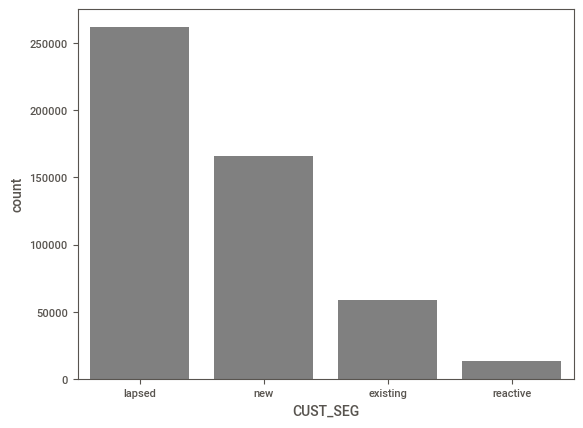

In [219]:
fig.suptitle('Bar plot for all categorical variables in the dataset')
sns.countplot(x = 'CUST_SEG', data = df2, color = 'grey', 
              order = df2['CUST_SEG'].value_counts().index);

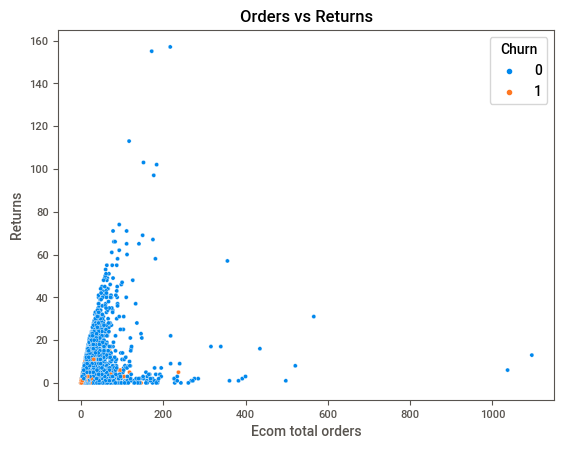

In [220]:
sns.scatterplot(data=df2, x='ECOM_TOTAL_ORDERS', y='ECOM_RETURNED_ORDERS', hue='CHURNED')
plt.title('Orders vs Returns')
plt.xlabel('Ecom total orders')
plt.ylabel('Returns')
plt.legend(title='Churn')
plt.show()

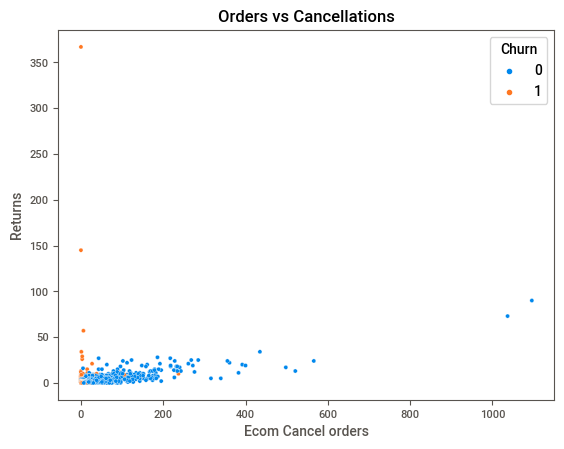

In [221]:
sns.scatterplot(data=df2, x='ECOM_TOTAL_ORDERS', y='CANCELLED_ORDERS', hue='CHURNED')
plt.title('Orders vs Cancellations')
plt.xlabel('Ecom Cancel orders')
plt.ylabel('Returns')
plt.legend(title='Churn')
plt.show()

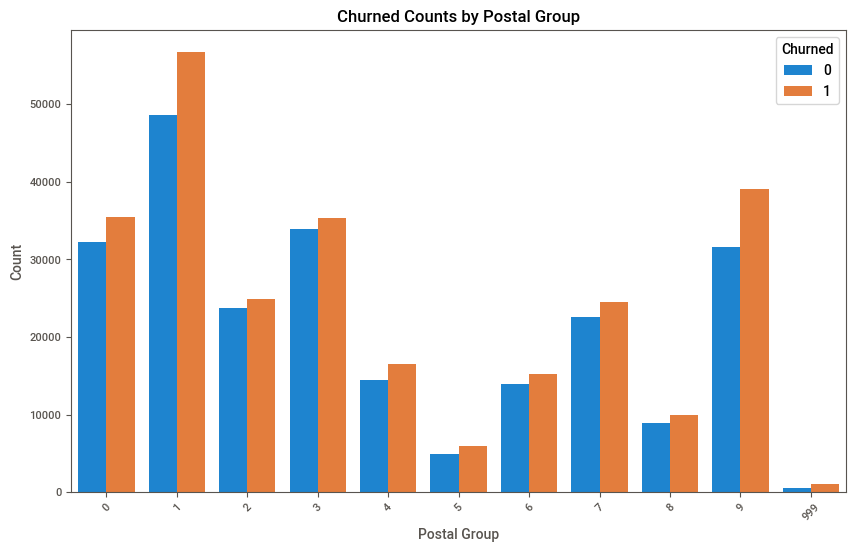

In [215]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df2, x='postal_group', hue='CHURNED')
plt.title('Churned Counts by Postal Group')
plt.xlabel('Postal Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Churned')
plt.show()

### Model

In [67]:
df2.CHURNED.replace({'YES': 1, 'NO': 0}, inplace = True)
print(df2.CHURNED.unique(), df2.CUST_SEG.unique())

[0 1] ['reactive' 'lapsed' 'new' 'existing']


In [68]:
train_df = df2[df2['CUST_SEG'] != 'new']
train_df.drop('CUST_SEG', axis=1, inplace=True, errors='ignore')
train_df = train_df.fillna(0)
train_df.shape

(334084, 74)

In [69]:
df_x = train_df.drop('CHURNED', axis=1) 
df_y = train_df['CHURNED']
xtrain, xval, ytrain, yval = train_test_split(df_x, df_y, test_size=0.2,random_state=10, shuffle=True, stratify=df_y)

test_df = df2[df2['CUST_SEG']=='new']
test_df.drop('CUST_SEG', axis=1, inplace=True, errors='ignore') 

print(xtrain.shape, xval.shape)
print(ytrain.shape, yval.shape)
print(test_df.shape)

(267267, 73) (66817, 73)
(267267,) (66817,)
(165916, 74)


In [70]:
xtrain_amp_df = xtrain['AMPERITY_ID']
xval_amp_df = xval['AMPERITY_ID']

xtrain.drop('AMPERITY_ID', axis=1, inplace=True)
xval.drop('AMPERITY_ID', axis=1, inplace=True)

In [71]:

scaler = MinMaxScaler(feature_range=(0,1))
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)

In [72]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(float(y_true) * float(y_pred), 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    print(y_pred.shape)
    print(y_true.shape)
    print('-------------------------')
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [73]:
model = Sequential([
    Dense(72, input_shape=(72,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(10,activation = 'relu'),
    # we use sigmoid for binary output
    # output layer
    Dense(1, activation='sigmoid')
    ])

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['acc', f1_m, precision_m, recall_m]
             )
# model.build()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 72)                5256      
                                                                 
 dense_17 (Dense)            (None, 64)                4672      
                                                                 
 dense_18 (Dense)            (None, 10)                650       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 10589 (41.36 KB)
Trainable params: 10589 (41.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
model.fit(xtrain, 
          ytrain, 
          epochs=5,
          batch_size = 128,
          # validation_split=0.3
          validation_data=(xval, yval)
         )

Epoch 1/5
(None, 1)
(None, 1)
-------------------------
(None, 1)
(None, 1)
-------------------------
2051/2089 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9038 - f1_m: 0.9414 - precision_m: 0.9026 - recall_m: 0.9844(None, 1)
(None, 1)
-------------------------
2089/2089 [==============================] - 1s 619us/step - loss: 0.2357 - acc: 0.9039 - f1_m: 0.9414 - precision_m: 0.9027 - recall_m: 0.9844 - val_loss: 0.2190 - val_acc: 0.9045 - val_f1_m: 0.9417 - val_precision_m: 0.9048 - val_recall_m: 0.9825
Epoch 2/5
2089/2089 [==============================] - 1s 561us/step - loss: 0.2148 - acc: 0.9058 - f1_m: 0.9425 - precision_m: 0.9057 - recall_m: 0.9830 - val_loss: 0.2121 - val_acc: 0.9048 - val_f1_m: 0.9423 - val_precision_m: 0.9006 - val_recall_m: 0.9886
Epoch 3/5
2089/2089 [==============================] - 1s 576us/step - loss: 0.2105 - acc: 0.9062 - f1_m: 0.9427 - precision_m: 0.9058 - recall_m: 0.9832 - val_loss: 0.2327 - val_acc: 0.9037 - val_f1_m: 0.94

In [76]:
train_preds = model.predict(xtrain)
val_preds = model.predict(xval)

2089/2089 [==============================] - 0s 201us/step


In [84]:
train_pred_df = pd.DataFrame({'actual' : ytrain,
             'pred_prob' : list(map(itemgetter(0), train_preds))
             })

train_pred_df['preds'] = train_pred_df.pred_prob.apply(lambda x : 1 if x>0.5 else 0)
train_pred_df

,actual,pred_prob,preds
72575,1,0.960875,1
318731,0,0.000028,0
317673,1,0.999676,1
423991,1,0.999471,1
120136,1,0.998934,1
...,...,...,...
84492,1,0.999422,1
58084,1,0.997148,1
261152,1,0.997029,1
164570,1,0.712596,1


In [85]:
val_pred_df = pd.DataFrame({'actual' : yval,
             'pred_prob' : list(map(itemgetter(0), val_preds))
             })

val_pred_df['preds'] = val_pred_df.pred_prob.apply(lambda x : 1 if x>0.5 else 0)
val_pred_df

,actual,pred_prob,preds
199620,1,0.844078,1
129557,1,0.800608,1
371238,1,0.999533,1
424416,0,0.000001,0
164771,1,0.999345,1
...,...,...,...
19307,1,0.851092,1
250804,1,0.997194,1
422463,0,0.612055,1
337836,1,0.997053,1


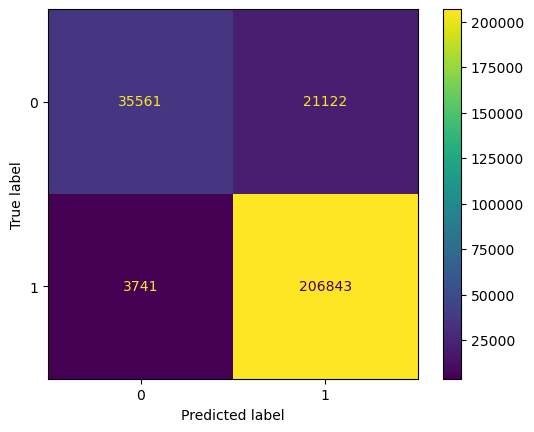

In [87]:
classes = np.unique(np.concatenate([val_pred_df['actual'], val_pred_df['preds']]))

train_cm = confusion_matrix(train_pred_df['actual'], train_pred_df['preds'], labels=classes)
ConfusionMatrixDisplay(train_cm, display_labels=classes).plot()

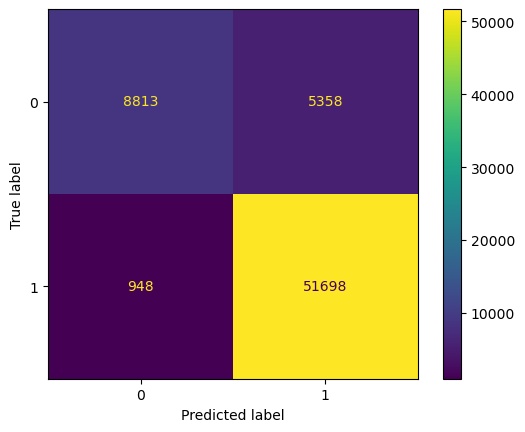

In [88]:
val_cm = confusion_matrix(val_pred_df['actual'], val_pred_df['preds'], labels=classes)
ConfusionMatrixDisplay(val_cm, display_labels=classes).plot()

In [89]:
print(train_cm)

train_tp = train_cm[1,1]
train_tn = train_cm[0,0]
train_fp = train_cm[0,1]
train_fn = train_cm[1,0]

print("\n",val_cm)

val_tp = val_cm[1,1]
val_tn = val_cm[0,0]
val_fp = val_cm[0,1]
val_fn = val_cm[1,0]

[[ 35561  21122]
 [  3741 206843]]

 [[ 8813  5358]
 [  948 51698]]


In [97]:
train_pred_df['AMPERITY_ID'] = df_x.loc[train_pred_df.index]['AMPERITY_ID']
val_pred_df['AMPERITY_ID'] = df_x.loc[val_pred_df.index]['AMPERITY_ID']
print("train data\n")
print(train_pred_df.head(3),"\n")
print("validation data\n")
print(val_pred_df.head(3))

train data

        actual  pred_prob  preds                           AMPERITY_ID
72575        1   0.960875      1  734bdaa4-c88b-3d61-a2f1-fc1fe41d90c6
318731       0   0.000028      0  59b96990-0442-375f-9885-944b4576b1ed
317673       1   0.999676      1  db81ec32-381d-3cac-8e85-2551b02ff041 

validation data

        actual  pred_prob  preds                           AMPERITY_ID
199620       1   0.844078      1  ce1838dc-9fe5-320d-8e74-7382e9d040aa
129557       1   0.800608      1  de707d89-12c0-3393-8ac0-c4c73baad9f3
371238       1   0.999533      1  63fc387b-0105-389e-aa5c-9ea8c764fbbb


In [99]:
train_acc = metrics.accuracy_score(train_pred_df['actual'], train_pred_df['preds'])
val_acc = metrics.accuracy_score(val_pred_df['actual'], val_pred_df['preds'])

train_f1 = metrics.f1_score(train_pred_df['actual'], train_pred_df['preds'])
val_f1 = metrics.f1_score(val_pred_df['actual'], val_pred_df['preds'])

print('train acc: {}  |  validation acc: {}'.format(train_acc, val_acc))
print('train f1: {}  |  validation f1: {}'.format(train_f1, val_f1))

train_sensitivity = train_tp/float(train_tp+train_fn)
print('\nTrain Sensitivity: {}'.format(round(train_sensitivity,2)))

train_specificity = train_tp/float(train_tp+train_fp)
print('Train Specificity: {}\n'.format(round(train_specificity,2)))

val_sensitivity = val_tp/float(val_tp+val_fn)
print('Validation Sensitivity: {}'.format(round(val_sensitivity,2)))

val_specificity = val_tp/float(val_tp+val_fp)
print('Validation Specificity: {}'.format(round(val_specificity,2)))

train acc: 0.906973176636098  |  validation acc: 0.905622820539683
train f1: 0.9433062211976313  |  validation f1: 0.9425170006016299

Train Sensitivity: 0.98
Train Specificity: 0.91

Validation Sensitivity: 0.98
Validation Specificity: 0.91


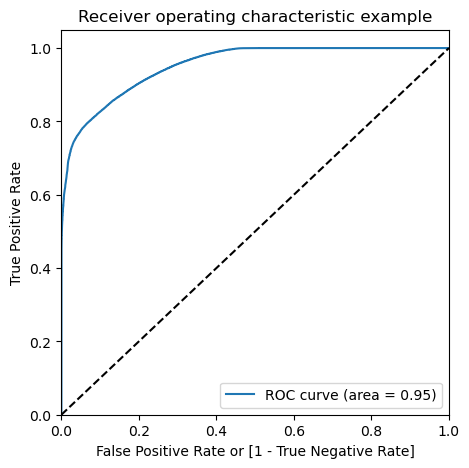

In [101]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

fpr, tpr, thresholds = metrics.roc_curve(val_pred_df['actual'], val_pred_df['pred_prob'], drop_intermediate = False )
draw_roc(train_pred_df['actual'], train_pred_df['pred_prob'])

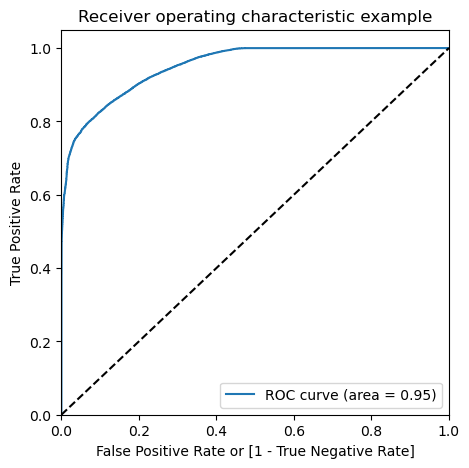

In [102]:
draw_roc(val_pred_df['actual'], val_pred_df['pred_prob'])

In [103]:
numbers = np.arange(0,1,0.05).round(2)   #[float(x)/10 for x in range(1)]
for i in numbers:
    train_pred_df[i]= train_pred_df.pred_prob.map(lambda x: 1 if x > i else 0)
train_pred_df.head(50)

,actual,pred_prob,preds,AMPERITY_ID,0.0,0.05,0.1,0.15,0.2,0.25,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
72575,1,0.960875,1,734bdaa4-c88b-3d61-a2f1-fc1fe41d90c6,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
318731,0,0.000028,0,59b96990-0442-375f-9885-944b4576b1ed,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317673,1,0.999676,1,db81ec32-381d-3cac-8e85-2551b02ff041,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
423991,1,0.999471,1,12ed5047-f90a-3678-8e4d-441270d1c301,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
120136,1,0.998934,1,75a508e1-6b3f-37f3-aba0-040b52df8889,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
122568,1,0.974941,1,e1ca557b-8c22-3b73-8270-da731fee59eb,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
282023,1,0.999533,1,4033ecc5-8816-38c0-9f6f-88783a3cbfbb,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
238916,1,0.989985,1,644172fb-bbc6-3421-a4ee-8990f15b2f1d,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
296285,1,0.999146,1,29f55456-ff68-3fd7-88b9-926dcaff9977,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
341108,1,0.999623,1,025ba356-1d0c-3a94-a269-813fc830a44f,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [104]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
for i in numbers:
    cm1 = metrics.confusion_matrix(train_pred_df.actual, train_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

      prob  accuracy     sensi     speci
0.00  0.00  0.787965  1.000000  0.000229
0.05  0.05  0.899973  0.999658  0.529630
0.10  0.10  0.900657  0.999601  0.533070
0.15  0.15  0.901043  0.999563  0.535028
0.20  0.20  0.901424  0.999478  0.537145
0.25  0.25  0.901877  0.999273  0.540038
0.30  0.30  0.902741  0.998647  0.546442
0.35  0.35  0.904141  0.996647  0.560468
0.40  0.40  0.905791  0.993452  0.580121
0.45  0.45  0.906722  0.988736  0.602032
0.50  0.50  0.906973  0.982235  0.627366
0.55  0.55  0.905701  0.972173  0.658751
0.60  0.60  0.902263  0.957024  0.698816
0.65  0.65  0.894439  0.934226  0.746626
0.70  0.70  0.879166  0.898098  0.808832
0.75  0.75  0.850902  0.842338  0.882716
0.80  0.80  0.822956  0.792629  0.935624
0.85  0.85  0.803339  0.761563  0.958541
0.90  0.90  0.785349  0.735265  0.971420
0.95  0.95  0.763274  0.705077  0.979482


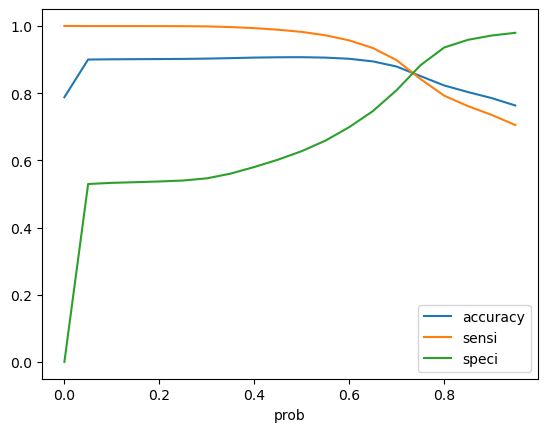

In [105]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [106]:
train_pred_df['final_preds'] = train_pred_df.pred_prob.apply(lambda x : 1 if x>0.75 else 0)
train_pred_df.head()

,actual,pred_prob,preds,AMPERITY_ID,0.0,0.05,0.1,0.15,0.2,0.25,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,final_preds
72575,1,0.960875,1,734bdaa4-c88b-3d61-a2f1-fc1fe41d90c6,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
318731,0,0.000028,0,59b96990-0442-375f-9885-944b4576b1ed,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317673,1,0.999676,1,db81ec32-381d-3cac-8e85-2551b02ff041,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
423991,1,0.999471,1,12ed5047-f90a-3678-8e4d-441270d1c301,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
120136,1,0.998934,1,75a508e1-6b3f-37f3-aba0-040b52df8889,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


train acc: 0.85
train f1: 0.90

Train ==> Sensitivity/Recall: 0.84 | Specificity: 0.96
Train ==> Precision: 0.96 | Recall: 0.84

[[ 50035   6648]
 [ 33201 177383]]


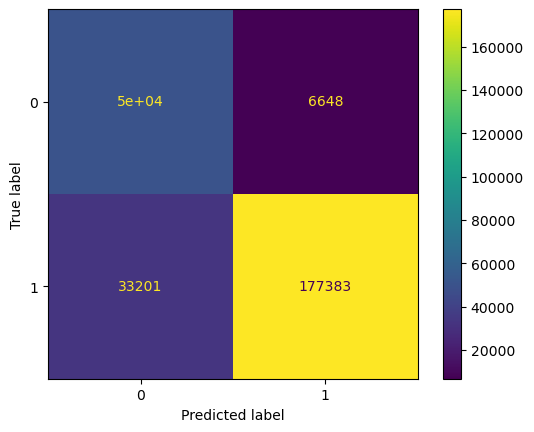

In [108]:
# Lets re-evaluate once again


train_acc = metrics.accuracy_score(train_pred_df['actual'], train_pred_df['final_preds'])

train_f1 = metrics.f1_score(train_pred_df['actual'], train_pred_df['final_preds'])

train_cm = confusion_matrix(train_pred_df['actual'], train_pred_df['final_preds'], labels=classes)
ConfusionMatrixDisplay(train_cm, display_labels=classes).plot()


train_tp = train_cm[1,1]
train_tn = train_cm[0,0]
train_fp = train_cm[0,1]
train_fn = train_cm[1,0]

train_sensitivity = train_tp/float(train_tp+train_fn)
train_specificity = train_tp/float(train_tp+train_fp)
train_precision = precision_score(train_pred_df['actual'], train_pred_df['final_preds'])

print('train acc: {:.2f}'.format(train_acc))
print('train f1: {:.2f}'.format(train_f1))

print('\nTrain ==> Sensitivity/Recall: {:.2f} | Specificity: {:.2f}'.format(train_sensitivity, train_specificity))

print('Train ==> Precision: {:.2f} | Recall: {:.2f}\n'.format(train_precision,train_sensitivity))

print(train_cm)

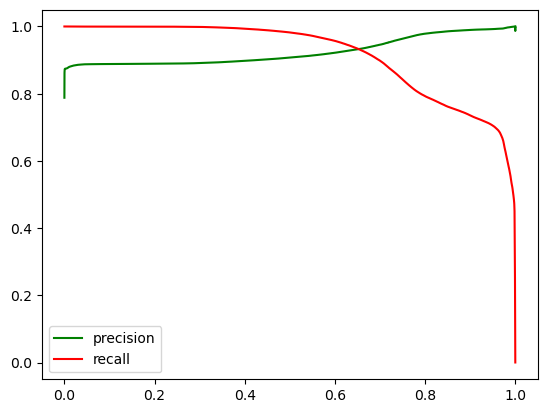

In [112]:
p, r, thresholds = precision_recall_curve(train_pred_df['actual'], train_pred_df['pred_prob'])
plt.plot(thresholds, p[:-1], "g-", label = 'precision')
plt.plot(thresholds, r[:-1], "r-", label = 'recall')
plt.legend()
plt.show()

In [113]:
for i,j,k in zip(thresholds, p[:-1],r[:-1]):
    if j == k:
        best_cutoff = i
        print('Best cut-off/threshold point for test data -> {:.2f}\nPrecision at Max -> {:.2f}\nRecall at Max -> {:.2f}'.format(i, j, k))

Best cut-off/threshold point for test data -> 0.65
Precision at Max -> 0.93
Recall at Max -> 0.93


train acc: 0.89
train f1: 0.93

Train ==> Sensitivity/Recall: 0.93 | Specificity: 0.93
Train ==> Precision: 0.93 | Recall: 0.93

[[ 42486  14197]
 [ 14198 196386]]


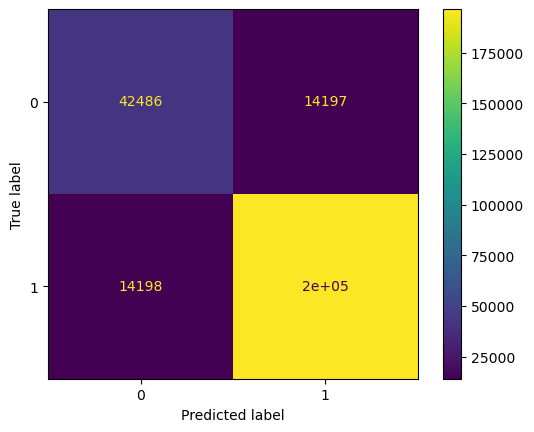

In [114]:
train_pred_df['final_preds'] = train_pred_df.pred_prob.apply(lambda x : 1 if x>best_cutoff else 0)
train_pred_df.head()

train_acc = metrics.accuracy_score(train_pred_df['actual'], train_pred_df['final_preds'])

train_f1 = metrics.f1_score(train_pred_df['actual'], train_pred_df['final_preds'])

train_cm = confusion_matrix(train_pred_df['actual'], train_pred_df['final_preds'], labels=classes)
ConfusionMatrixDisplay(train_cm, display_labels=classes).plot()


train_tp = train_cm[1,1]
train_tn = train_cm[0,0]
train_fp = train_cm[0,1]
train_fn = train_cm[1,0]

train_sensitivity = train_tp/float(train_tp+train_fn)
train_specificity = train_tp/float(train_tp+train_fp)
train_precision = precision_score(train_pred_df['actual'], train_pred_df['final_preds'])

print('train acc: {:.2f}'.format(train_acc))
print('train f1: {:.2f}'.format(train_f1))

print('\nTrain ==> Sensitivity/Recall: {:.2f} | Specificity: {:.2f}'.format(train_sensitivity, train_specificity))

print('Train ==> Precision: {:.2f} | Recall: {:.2f}\n'.format(train_precision,train_sensitivity))

print(train_cm)

val acc: 0.89
val f1: 0.93

Validation ==> Sensitivity/Recall: 0.93 | Specificity: 0.93
Validation ==> Precision: 0.93 | Recall: 0.93

[[10562  3609]
 [ 3534 49112]]


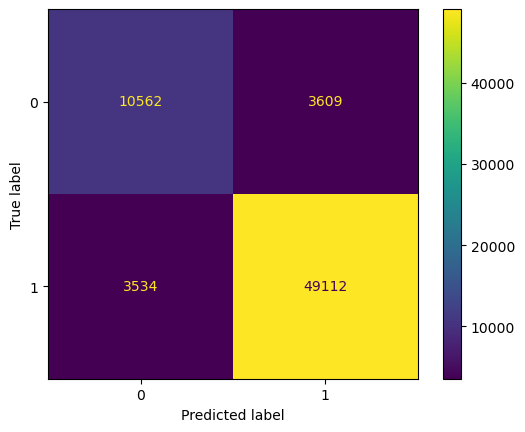

In [115]:
val_pred_df['final_preds'] = val_pred_df.pred_prob.apply(lambda x : 1 if x>best_cutoff else 0)
val_pred_df.head()

val_acc = metrics.accuracy_score(val_pred_df['actual'], val_pred_df['final_preds'])

val_f1 = metrics.f1_score(val_pred_df['actual'], val_pred_df['final_preds'])

val_cm = confusion_matrix(val_pred_df['actual'], val_pred_df['final_preds'], labels=classes)
ConfusionMatrixDisplay(val_cm, display_labels=classes).plot()


val_tp = val_cm[1,1]
val_tn = val_cm[0,0]
val_fp = val_cm[0,1]
val_fn = val_cm[1,0]

val_sensitivity = val_tp/float(val_tp + val_fn)
val_specificity = val_tp/float(val_tp + val_fp)
val_precision = precision_score(val_pred_df['actual'], val_pred_df['final_preds'])

print('val acc: {:.2f}'.format(val_acc))
print('val f1: {:.2f}'.format(val_f1))

print('\nValidation ==> Sensitivity/Recall: {:.2f} | Specificity: {:.2f}'.format(val_sensitivity, val_specificity))

print('Validation ==> Precision: {:.2f} | Recall: {:.2f}\n'.format(val_precision,val_sensitivity))

print(val_cm)
